# MXN442 Assignment 1
- Student Number: 10515402
- First Name: Aidan
- Last Name: Lockwood

## Assignment Setup
Installing required libraries

In [463]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ISLP import confusion_table
from ISLP.models import ModelSpec as MS, Stepwise, sklearn_selected, sklearn_selection_path, summarize

from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import statsmodels.api as sm
import seaborn as sns

import warnings

from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import sklearn.linear_model as skl
import sklearn.model_selection as skm

warnings.filterwarnings('ignore')
%xmode Minimal


Exception reporting mode: Minimal


Loading required data

In [464]:
df = pd.read_csv('data/assignment1_data.csv')
df

,age,income,credit_score,years_employed,debt_to_income,num_credit_cards,education,marital_status,credit_limit,loan_default
0,52,25874.0,569,3.9,0.269,5,1,0,9131,0
1,43,NaN,613,0.1,0.059,5,0,1,9690,0
2,55,20000.0,578,18.3,0.088,2,2,1,15311,0
3,68,27887.0,663,6.0,0.182,3,3,0,13221,0
4,41,65268.0,794,15.2,0.162,3,3,0,24805,0
...,...,...,...,...,...,...,...,...,...,...
4995,44,102835.0,541,3.5,0.134,3,0,1,22262,0
4996,56,20000.0,798,NaN,0.288,3,2,1,8700,0
4997,80,20656.0,807,7.6,0.252,5,1,1,9876,0
4998,57,53993.0,544,3.4,0.422,2,1,1,8790,0


## Question 1: Linear Regression and Model Selection (12 Marks)

Banks need to set appropriate credit limits for customers based on their financial profiles. Setting limits too low may result in lost revenue opportunities, while setting them too high increases exposure to potential losses. The challenge is to develop a model that can accurately predict optimal credit limits using customer demographic, financial, and behavioural characteristics.

<b>a) Multiple Linear Regression (3 marks) </b>
- Handle missing values using mean imputation 
- Split data into training (70%) and test (30%) sets. Fit a multiple linear regression model using all features to predict `credit_limit` (1) 
- Interpret the coefficients of the three most significant predictors (1)

Handling the missing values using mean imputation

In [465]:
# Checking for the missing values in the dataset
data_columns = df.columns.to_list()

for column in data_columns:
    print(f'Column {column} has {df[column].isna().sum()} missing values')

Column age has 0 missing values
Column income has 150 missing values
Column credit_score has 0 missing values
Column years_employed has 150 missing values
Column debt_to_income has 0 missing values
Column num_credit_cards has 0 missing values
Column education has 0 missing values
Column marital_status has 0 missing values
Column credit_limit has 0 missing values
Column loan_default has 0 missing values


It appears that both `income` and `years_employed` have missing values. Thus the mean will be calculated for those values. The mean for each variable will be input into the NaN values

In [466]:
# Calculating the mean values 
mean_income = round(df['income'].mean(), 2)
mean_years_employed = round(df['years_employed'].mean(), 2)

# Replacing the NaN values for each column with their respective means 
df['income'] = df['income'].fillna(mean_income)
df['years_employed'] = df['years_employed'].fillna(mean_years_employed)

# Checking the fill worked
for column in data_columns:
    print(f'Column {column} has {df[column].isna().sum()} missing values')

Column age has 0 missing values
Column income has 0 missing values
Column credit_score has 0 missing values
Column years_employed has 0 missing values
Column debt_to_income has 0 missing values
Column num_credit_cards has 0 missing values
Column education has 0 missing values
Column marital_status has 0 missing values
Column credit_limit has 0 missing values
Column loan_default has 0 missing values


The mean imputation has been completed.

Now time to split data into training and test splits, then generate a multiple linear regression model, fitting it to the training data.

In [467]:
q1_data = df.drop(columns = ['credit_limit', 'loan_default'])
X_train, X_test, Y_train, Y_test = skm.train_test_split(q1_data, df['credit_limit'], test_size=0.3, random_state=42)


In [468]:
Y_train.value_counts()

credit_limit
11765    4
12059    4
14108    4
16912    3
13630    3
        ..
11129    1
13012    1
4526     1
13107    1
20729    1
Name: count, Length: 3213, dtype: int64

Now to fit the data to a MLR.
Note that:
- `credit_limit` is the response variable

In [469]:
training_predictors = df.columns.drop(['credit_limit', 'loan_default'])

train_design = MS(training_predictors)
train_design = train_design.fit(df)


# Experimenting with adjusting the scaling of the variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_train_scaled['education'] = df['education']
X_train_scaled['marital_status'] = df['marital_status']

Y = np.array(df['credit_limit'])
mlr_model = sm.OLS(Y_train, X_train)

mlr_results = mlr_model.fit()

mlr_results.summary()

## The result of standardising the X_train put the condition number to infinity
## Not standardising but adding all variables minus the response resulted in a large condition number

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:           credit_limit   R-squared (uncentered):                   0.990
Model:                            OLS   Adj. R-squared (uncentered):              0.990
Method:                 Least Squares   F-statistic:                          4.373e+04
Date:                Sun, 24 Aug 2025   Prob (F-statistic):                        0.00
Time:                        17:14:25   Log-Likelihood:                         -30968.
No. Observations:                3500   AIC:                                  6.195e+04
Df Residuals:                    3492   BIC:                                  6.200e+04
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
age                  5.9624      1.801      3.310      0.001       2.431       9.494
income               0.1525      0.001    237.442      0.000       0.151       0.154
credit_score        10.6054      0.159     66.778      0.000      10.294      10.917
years_employed     354.8530      3.569     99.425      0.000     347.855     361.851
debt_to_income   -1.444e+04    221.857    -65.071      0.000   -1.49e+04    -1.4e+04
num_credit_cards  -180.8260     15.979    -11.317      0.000    -212.155    -149.498
education          704.9804     28.987     24.320      0.000     648.147     761.814
marital_status      38.4573     40.595      0.947      0.344     -41.134     118.049
==============================================================================
Omnibus:                     4580.814   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2300199.905
Skew:                           6.852   Prob(JB):                         0.00
Kurtosis:                     127.840   Cond. No.                     5.24e+05
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 5.24e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The three most significant predictors are `income`, `credit_score` and `years_employed`. The coefficients for those variables are 0.151, 8.7822 and 351.6655 respectively. The low coefficient value for `income` suggests that while there is a significant relationship between `income` and `credit_limit`, it has a small affect on the response. Conversely, `years_employed` appears to significantly increase the customer's credit limit. Outside of these variables, it appears that an increase to the `debt_to_income` ratio, in addition to `num_credit_cards`, substantially reduces the credit limit. 

From the model results, the condition number appears to be quite large. This is indicative that multicolinearity exists within the variables of the model.


<b>b) Model Selection (4 marks)</b>
- Implement forward selection using AIC (1)
- Implement backward elimination using AIC (1)
- Compare the selected variables from both methods. Discuss which approach selects more variables and why (1)

Defining an AIC scoring function to help score the two models from forward and backward selection

In [470]:
def negAIC(estimator, X, Y):
    "Negative AIC"
    n, p = X.shape
    Yhat = estimator.predict(X)
    MSE = np.mean((Y - Yhat)**2)
    return n + n * np.log(MSE) + 2 * (p + 1)

Applying forward selection using AIC

In [471]:
Y_train = np.array(Y_train)
X_train_transform = train_design.transform(X_train)

# Then defining the strategy to then fit to a linear regression task
forward_select_strategy = Stepwise.first_peak(train_design, 
                                              direction = 'forward',
                                              max_terms = len(train_design.terms))

# using sklearn_selected to fit a linear regression
forward_select_model = sklearn_selected(sm.OLS, 
                                        forward_select_strategy,
                                        scoring = negAIC)

forward_select_model.fit(X_train_transform, Y_train)
forward_select_model.selected_state_

('age', 'marital_status')

Now generating the predictions off the Forward Selection Model

In [472]:
forward_selected_path = sklearn_selection_path(sm.OLS, forward_select_strategy)
forward_selected_path.fit(df, np.array(df['credit_limit']))
Y_hat_forward = forward_selected_path.predict(X_test)
Y_hat_forward.shape


(1500, 9)

In [473]:
Y_test_np = np.array(Y_test)

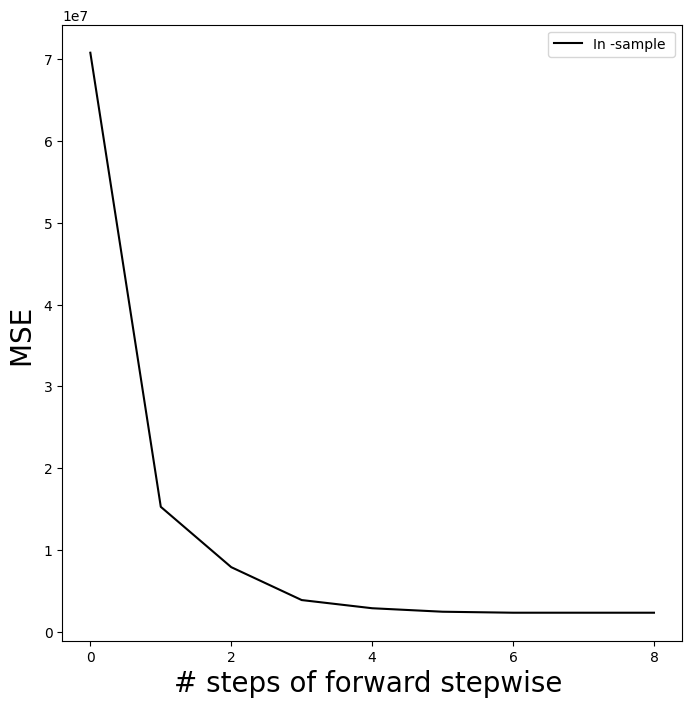

In [474]:
mse_fig , ax = plt.subplots (figsize =(8 ,8))
insample_mse = (( Y_hat_forward - Y_test_np[:,None])**2).mean(0)
n_steps = insample_mse.shape[0]
ax.plot(np.arange(n_steps),
insample_mse ,
'k', # color black
label='In -sample ')
ax. set_ylabel ('MSE ',
fontsize =20)
ax. set_xlabel ('# steps of forward stepwise ',
fontsize =20)
ax. set_xticks (np.arange(n_steps)[::2])
ax.legend ()

Applying backward elimination with AIC

In [475]:
backward_select_strategy = Stepwise.first_peak(train_design,
                                               direction = 'backwards',
                                               max_terms = len(train_design.terms))

backward_select_model = sklearn_selected(sm.OLS,
                                         backward_select_strategy,
                                         scoring = negAIC)

backward_select_model.fit(X_train_transform, Y_train)
backward_select_model.selected_state_

('age', 'marital_status')

In [476]:
backward_selected_path = sklearn_selection_path(sm.OLS, backward_select_strategy)

backward_selected_path.fit(df, df['credit_limit'])
Y_hat_backward = backward_selected_path.predict(X_test)
Y_hat_backward.shape

(1500, 10)

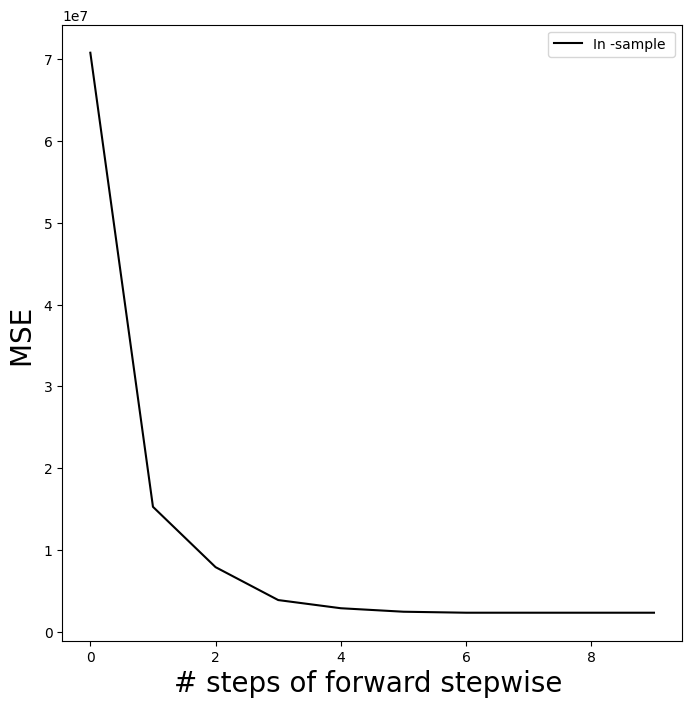

In [477]:
mse_fig , ax = plt.subplots (figsize =(8 ,8))
insample_mse = (( Y_hat_backward - Y_test_np[:, None ])**2).mean (0)
n_steps = insample_mse.shape [0]
ax.plot(np.arange(n_steps),
insample_mse ,
'k', # color black
label='In -sample ')
ax. set_ylabel ('MSE ',
fontsize =20)
ax. set_xlabel ('# steps of forward stepwise ',
fontsize =20)
ax. set_xticks (np.arange(n_steps)[::2])
ax.legend ()

Compare the selected variables from both methods. Discuss which approach selects more variables and why?

It appears that both forward and backwards model selection chooses the same variables, with age and marital status

<b>c) Regularisation (5 marks)</b>
- Implement Ridge and Lasso Regression with 5-fold cross validation (2)
- Plot the cross-validation error vs lambda for both methods (1)
- Calculate test set RMSE for all five models (full, forward, backward, Ridge, Lasso) (2)

Implementing Ridge and Lasso Regression with 5-fold cross-validation

In [478]:
# Ridge Regression 
regression_design = train_design.fit_transform(df)
regression_design = regression_design.drop(columns=['intercept'])
X = np.asarray(regression_design)

# Standardising the columns 
X_standard = np.array(X_train).mean(0)[None,:]
X_standard
X_scale = np.array(X_train).std(0)
X_standard = X_standard / X_scale [None,:]

lambdas = 10 ** np.linspace(8,-2, 100) / Y.std()

ridge_model = skl.ElasticNet(alpha = lambdas[50], l1_ratio = 0)
scaler = StandardScaler(with_mean = True, with_std = True)
ridge_pipeline = Pipeline(steps = [('scaler', scaler), ('ridge', ridge_model)])
ridge_pipeline.fit(X, np.array(df['credit_limit']))

,steps,"[('scaler', ...), ('ridge', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,alpha,np.float64(0....1136331616971)
,l1_ratio,0
,fit_intercept,True
,precompute,False


In [479]:
# Applying 5-Fold Cross-Validation
K = 5
kfold = skm.KFold(K,
                    random_state = 0,
                    shuffle = True)

parameter_grid = {'ridge__alpha' : lambdas}

grid = skm.GridSearchCV(ridge_pipeline,
                        parameter_grid,
                        cv = kfold,
                        scoring = 'neg_mean_squared_error')
grid.fit(X_train, Y_train)
grid.best_params_['ridge__alpha']
grid.best_estimator_

,steps,"[('scaler', ...), ('ridge', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,alpha,np.float64(0....3767847745324)
,l1_ratio,0
,fit_intercept,True
,precompute,False


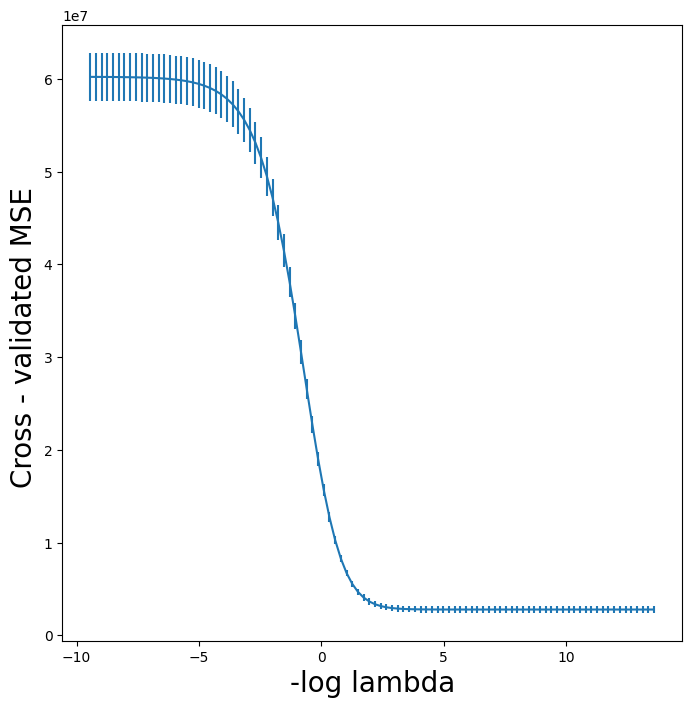

In [480]:
ridge_fig , ax = plt.subplots(figsize =(8 ,8))
ax.errorbar(-np.log(lambdas),
            -grid.cv_results_['mean_test_score'],
            yerr=grid.cv_results_['std_test_score'] / np.sqrt(K))
ax. set_xlabel('-log lambda', fontsize =20)
ax. set_ylabel('Cross - validated MSE ', fontsize =20);

Applying Lasso Regression

In [481]:
lasso_model = skl.ElasticNet(alpha = lambdas[50], l1_ratio = 1)
scaler = StandardScaler(with_mean = True, with_std = True)
lasso_pipeline = Pipeline(steps = [('scaler', scaler), ('lasso', lasso_model)])
lasso_pipeline.fit(X, np.array(df['credit_limit']))

,steps,"[('scaler', ...), ('lasso', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,alpha,np.float64(0....1136331616971)
,l1_ratio,1
,fit_intercept,True
,precompute,False


In [482]:
# Applying 5-Fold Cross-Validation
K = 5
kfold = skm.KFold(K,
                    random_state = 0,
                    shuffle = True)

parameter_grid = {'lasso__alpha' : lambdas}

grid = skm.GridSearchCV(lasso_pipeline,
                        parameter_grid,
                        cv = kfold,
                        scoring = 'neg_mean_squared_error')
grid.fit(X_train, Y_train)
grid.best_params_['lasso__alpha']
grid.best_estimator_

,steps,"[('scaler', ...), ('lasso', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,alpha,np.float64(9.282775814187097)
,l1_ratio,1
,fit_intercept,True
,precompute,False


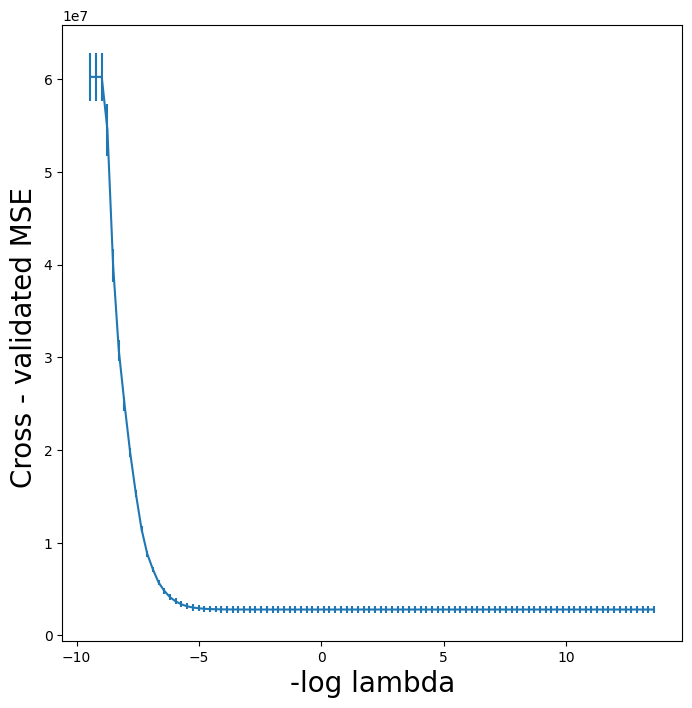

In [483]:
lasso_fig , ax = plt.subplots(figsize =(8 ,8))
ax.errorbar(-np.log(lambdas),
            -grid.cv_results_['mean_test_score'],
            yerr=grid.cv_results_['std_test_score'] / np.sqrt(K))
ax. set_xlabel('-log lambda', fontsize =20)
ax. set_ylabel('Cross - validated MSE ', fontsize =20);

Now Calculating the MSE for all models

In [484]:
# MLR MSE
mse_mlr = mean_squared_error(Y_test, mlr_results.predict(X_test))
mse_forward_select = mean_squared_error(Y_test, forward_select_model.predict(X_test))
mse_backward_select = mean_squared_error(Y_test, backward_select_model.predict(X_test))
mse_ridge = mean_squared_error(Y_test, ridge_model.predict(X_test))
mse_lasso = mean_squared_error(Y_test, lasso_model.predict(X_test))

print('Multiple Linear Regression MSE:', mse_mlr)
print('Forward Selection MSE:', mse_forward_select)
print('Backward Selection MSE:', mse_backward_select)
print('Ridge Regression MSE:', mse_ridge)
print('Lasso Regression MSE:', mse_lasso)

Multiple Linear Regression MSE: 2445151.639929102
Forward Selection MSE: 70880061.80787352
Backward Selection MSE: 70880061.80787352
Ridge Regression MSE: 1.9802975380213542e+17
Lasso Regression MSE: 2.4440045824448093e+17


Looking at the different MSEs for each model, it appears that Ridge and Lasso Regression significantly improve the error of the model. Ridge Regularisation appears to slightly outperform the Lasso Regularisation.

## Question 2: Dimension Reduction (8 marks)

<b>a) Principal Component Analysis (4 marks)</b>
- Perform PCA on the numerical features (age, income, credit_score, years_employed, debt_to_income, num_credit_cards) (1)
- Determine how many components explain 90% of the variance (1)
- Interpret the first two principal components by examining their loadings (1)
- Create a scatter plot of the first two principal components (1)

Performing PCA on the numerical features of the data

In [485]:
q2_data = df.drop(columns = ['education', 'marital_status', 'loan_default'])
# q2_data = np.asarray(q2_data)
q2_data

,age,income,credit_score,years_employed,debt_to_income,num_credit_cards,credit_limit
0,52,25874.00,569,3.90,0.269,5,9131
1,43,51458.37,613,0.10,0.059,5,9690
2,55,20000.00,578,18.30,0.088,2,15311
3,68,27887.00,663,6.00,0.182,3,13221
4,41,65268.00,794,15.20,0.162,3,24805
...,...,...,...,...,...,...,...
4995,44,102835.00,541,3.50,0.134,3,22262
4996,56,20000.00,798,8.26,0.288,3,8700
4997,80,20656.00,807,7.60,0.252,5,9876
4998,57,53993.00,544,3.40,0.422,2,8790


In [486]:
pca = PCA(n_components = 6)
linear_regression = skl.LinearRegression()
pca_pipeline = Pipeline([('scaler', StandardScaler()),
                     ('pca', pca),
                     ('linear_regression', linear_regression)])

pca_pipeline.fit(q2_data, df['credit_limit'])

,steps,"[('scaler', ...), ('pca', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_components,6
,copy,True
,whiten,False
,svd_solver,'auto'


Determining how many components explain 90% of the variance

In [487]:
explained_variance = pca_pipeline.named_steps['pca'].explained_variance_ratio_

In [488]:
value = 0
for i, val in enumerate(explained_variance):
    value += val
    print(f'Component {i + 1} explains {round(value * 100, 2)}% of the data')


Component 1 explains 28.43% of the data
Component 2 explains 43.34% of the data
Component 3 explains 57.89% of the data
Component 4 explains 72.21% of the data
Component 5 explains 86.0% of the data
Component 6 explains 99.65% of the data


Based on the above PCA transformation, 5 components explains 86% of the data, while 6 components explains 99.65% of the data. Therefore, the number of components that can explain 90% of the data is 6 components

Analysing the loadings of the first two principal components

First Component

In [489]:
pca_pipeline.named_steps['pca'].components_[0]

array([-0.01904137,  0.62708596,  0.07925306,  0.27546738, -0.16241927,
       -0.04256701,  0.70430486])

Second Component

In [490]:
pca_pipeline.named_steps['pca'].components_[1]

array([ 0.29931109,  0.09031461, -0.6069875 ,  0.39105817,  0.61580322,
        0.03903157, -0.01259982])

Between the first and second components, it can be seen that the variables contribute strongly toward the first component. While there are small values close to 0 in both components, 2 values in the first component - 0.62 and 0.7 - are the largest. These values correlate to `income` and `credit_limit`, which have the biggest variance in the data for the first component. For the second component, `years_employed` and `debt_to_income` have the largest values, indicating they have the biggest influence on the variance in the data.

<b>b) PCR and PLS Comparison (4 marks)</b>
- Implement Principal Component Regression (PCR) using cross-validation (1)
- Implement Partial Least Squares (PLS) regression using cross-validation (1)
- Plot cross-validation error vs number of components for both methods (1)
- Compare PCR and PLS test performances with your best model from Question 1 (1)

Performing PCR using Cross Validation

In [491]:
parameter_grid = {'pca__n_components': [2, 4, 6]}

grid = skm.GridSearchCV(pca_pipeline,
                        parameter_grid,
                        cv = kfold,
                        scoring = 'neg_mean_squared_error')

grid.fit(X_train, Y_train)

,estimator,Pipeline(step...egression())])
,param_grid,"{'pca__n_components': [2, 4, ...]}"
,scoring,'neg_mean_squared_error'
,n_jobs,None
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


Plotting the cross validation error vs the number of components for PCR

(11179619.585482763, 44112892.407283925)

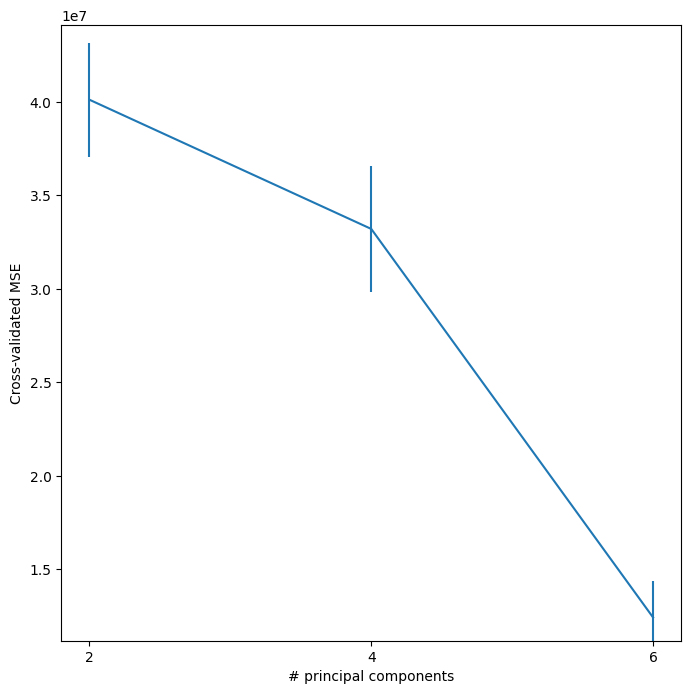

In [492]:
pcr_fig, ax = plt.subplots(figsize=(8, 8))
num_components = parameter_grid['pca__n_components']
mean_scores = -grid.cv_results_['mean_test_score']  
std_scores = grid.cv_results_['std_test_score'] / np.sqrt(K)

ax.errorbar(num_components, mean_scores, std_scores)
ax.set_ylabel('Cross-validated MSE',)
ax.set_xlabel('# principal components')
ax.set_xticks(num_components) 
ax.set_ylim([mean_scores.min() * 0.9, mean_scores.max() * 1.1])

Implementing PLS on the dataset

In [493]:
pls = PLSRegression(n_components = 2, scale = True)
pls.fit(X_train, Y_train)

,n_components,2
,scale,True
,max_iter,500
,tol,1e-06
,copy,True


In [494]:
parameter_grid = {'n_components' : range(1, 9)}

grid = skm.GridSearchCV(pls, 
                        parameter_grid, 
                        cv = kfold,
                        scoring = 'neg_mean_squared_error')

grid.fit(X_train, Y_train)

,estimator,PLSRegression()
,param_grid,"{'n_components': range(1, 9)}"
,scoring,'neg_mean_squared_error'
,n_jobs,None
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_components,2


Plotting the Cross Validation Error vs the number of components

(2516425.5014823563, 3227980.5355558363)

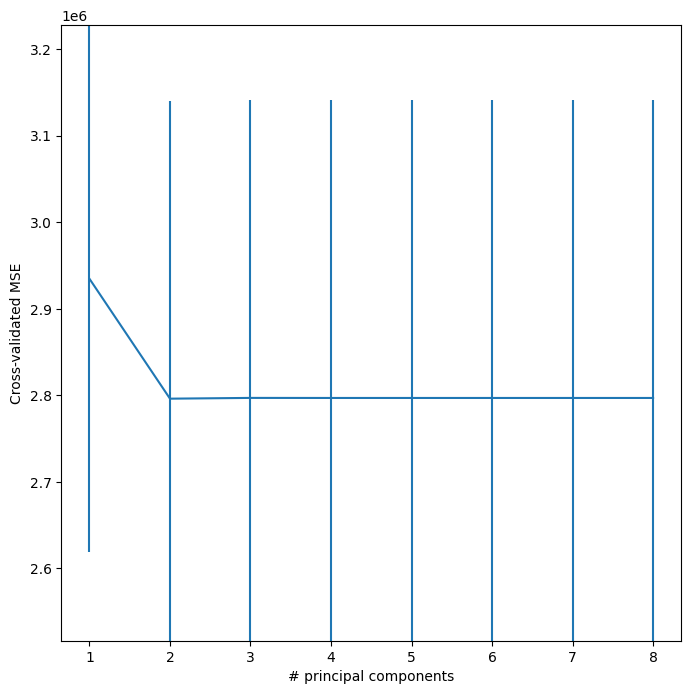

In [495]:
pcr_fig, ax = plt.subplots(figsize=(8, 8))
num_components = parameter_grid['n_components']
mean_scores = -grid.cv_results_['mean_test_score']  
std_scores = grid.cv_results_['std_test_score'] / np.sqrt(K)

ax.errorbar(num_components, mean_scores, std_scores)
ax.set_ylabel('Cross-validated MSE',)
ax.set_xlabel('# principal components')
ax.set_xticks(num_components) 
ax.set_ylim([mean_scores.min() * 0.9, mean_scores.max() * 1.1])

Comparing the PCR and PLS test performances

Between the PCR and PLS, it appears that the PLS has better performance using fewer components. When comparing the MSE of each, the Cross-Validation for PLS is around 2.8 x 10<sup>6</sup>.Conversely, the PCR has a Cross-Validation MSE of 1.1 x 10<sup>7</sup>, meaning the PLS performs better than the PCR on this dataset. 

When comparing these values against the Linear Regression, and the regularised methods, the performance of PLS is far inferior to the regularised methods, but is better than the multiple linear regression methods when comparing the MSE. 

## Question 3: Classification (10 marks)

Identifying customers likely to default on their loans is essential for risk management. Early identification allows banks to take preventative measures, adjust terms, or decline high-risk applications. This requires building classification models that can distinguish between customers who will successfully repay loans and those who may default.

<b>a) Logistic Regression (4 marks)</b>
- Fit a logistic regression model to predict `loan_default` (2)
- Calculate accuracy, precision, recall, and F1-score on the test set (1)
- Create an ROC curve and report the AUC (1)

In [496]:
q3_data = df.drop(columns=['loan_default'])

X_train, X_test, Y_train, Y_test = skm.train_test_split(q3_data, df['loan_default'], test_size=0.3, random_state=42)
    
q3_design = MS(q3_data.columns.to_list())
X_train = q3_design.fit_transform(X_train)
X_test = q3_design.fit_transform(X_test)

glm = sm.GLM(Y_train, X_train, family=sm.families.Binomial())
results = glm.fit()
summarize(results)

,coef,std err,z,P>|z|
intercept,-1.600000,1.858000,-0.861,0.389
age,0.003900,0.017000,0.226,0.822
income,-0.000002,0.000034,-0.067,0.946
credit_score,-0.000100,0.003000,-0.050,0.960
years_employed,-0.042800,0.089000,-0.482,0.630
debt_to_income,-3.666400,3.749000,-0.978,0.328
num_credit_cards,-0.110800,0.160000,-0.695,0.487
education,-0.491400,0.302000,-1.629,0.103
marital_status,0.146300,0.361000,0.405,0.685
credit_limit,-0.000200,0.000000,-0.756,0.450


Predicting Loan Default

In [497]:
logistic_predict = results.predict(X_test)

# Rounding the values for the confusion matrix
logistic_class = (logistic_predict >= 0.5).astype(int)

confusion_table(logistic_class, Y_test)


Truth,0,1
Predicted,,
0,1492,8
1,0,0


Calculating Accuracy, Precision, Recall and F1-Score on the Test set

In [498]:
logistic_accuracy = (logistic_class == Y_test).mean()
logistic_precision = (logistic_class & Y_test).sum() / logistic_class.sum()
logistic_recall = (logistic_class & Y_test).sum() / Y_test.sum()
logistic_f1 = 2 * (logistic_precision * logistic_recall) / (logistic_precision + logistic_recall)

print("Accuracy:", logistic_accuracy)
print("Precision:", logistic_precision)
print("Recall:", logistic_recall)
print("F1 Score:", logistic_f1)

Accuracy: 0.9946666666666667
Precision: nan
Recall: 0.0
F1 Score: nan


It appears that while the accuracy is high on the overall test set, the values for Precision, Recall and F1-Score are 0 or undefined because there are no positive predictions made of the data. 

<b>b) Linear Discriminant Analysis (4 marks)</b>
- Implement Linear Discriminant Analysis (LDA) for the classification problem (2)
- Compare LDA performance with logistic regression using the same metrics (1)
- Create a confusion matrix for LDA predictions (1)

Fitting the LDA to the training data

In [499]:
lda = LDA(store_covariance = True)
lda.fit(X_train, Y_train)

,solver,'svd'
,shrinkage,None
,priors,None
,n_components,None
,store_covariance,True
,tol,0.0001
,covariance_estimator,None


Predicting the classes on the test set using LDA

In [500]:
lda_predict = lda.predict(X_test)

Calculating the performance metrics on the test set

In [501]:
model_conf_table = confusion_table(lda_predict, Y_test)
model_conf_table

Truth,0,1
Predicted,,
0,1492,8
1,0,0


In [502]:
lda_accuracy = sum(lda_predict == Y_test) / len(Y_test)
lda_precision = sum((lda_predict == 1) & (Y_test == 1)) / sum(lda_predict == 1)
lda_recall = sum((lda_predict == 1) & (Y_test == 1)) / sum(Y_test == 1)
lda_f1_score = 2 * (lda_precision * lda_recall) / (lda_precision + lda_recall)

print("Accuracy:", lda_accuracy)
print("Precision:", lda_precision)
print("Recall:", lda_recall)
print("F1 Score:", lda_f1_score)

Accuracy: 0.9946666666666667
Precision: nan
Recall: 0.0
F1 Score: nan


<b>c) Model Comparison (2 marks)</b>
- Create a summary table comparing two classification methods (1)
- Discuss which method performs best and provide any insights you could (1)

In [503]:
model_comparison = pd.DataFrame({
    "Model": ["Logistic Regression", "LDA"],
    "Accuracy": [logistic_accuracy, lda_accuracy],
    "Precision": [logistic_precision, lda_precision],
    "Recall": [logistic_recall, lda_recall],
    "F1 Score": [logistic_f1, lda_f1_score]
})

model_comparison

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.994667,NaN,0.0,NaN
1,LDA,0.994667,NaN,0.0,NaN


It is like that due to the heavy class imbalance of the dataset, it appears that both models do not perform well for both classes, predicting that all users will not default on their loans. 